# Computer Vision Projects

## Mosaicing and image stiching

In [25]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

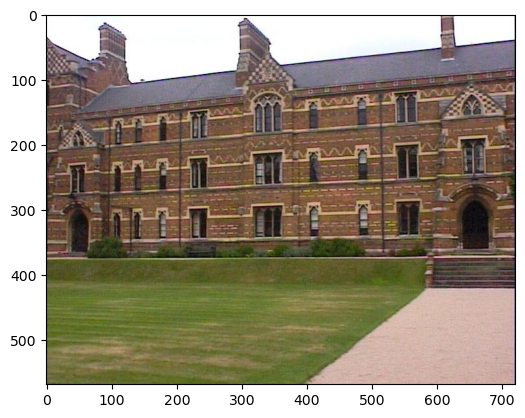

In [26]:
img_a = cv2.imread('./images/keble_a.jpg')
img_rgb_a = cv2.cvtColor(img_a, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb_a)

In [27]:
def get_the_N_information(image, n=200):
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(image, None)
    print('The number of keypoints with sift is {}'.format(len(keypoints)))

    # Convierte los keypoints en un array de NumPy para el valor de respuesta
    responses = np.array([kp.response for kp in keypoints])

    # Ordena los índices de los keypoints basados en la respuesta
    indices = np.argsort(responses)[::-1]

    # Reordena los keypoints usando los índices ordenados
    keypoints_sorted = [keypoints[i] for i in indices][:200]
    descriptors_sorted = descriptors[indices][:200]

    img_kp = cv2.drawKeypoints(image, keypoints_sorted, None, color=(255,0,0))
    plt.imshow(img_kp)
    return keypoints_sorted, descriptors_sorted

The number of keypoints with sift is 4055


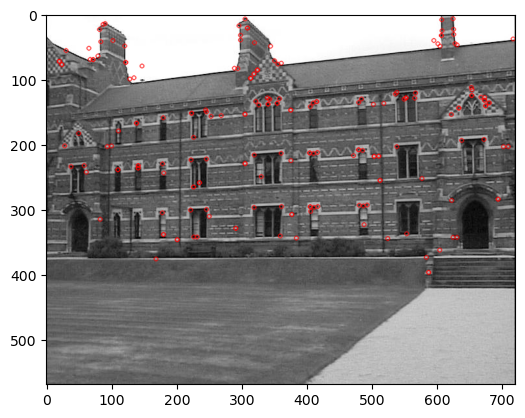

In [28]:
img_gs_a = cv2.imread('./images/keble_a.jpg', cv2.IMREAD_GRAYSCALE)
kp_a, d_a = get_the_N_information(img_gs_a)

The number of keypoints with sift is 4187


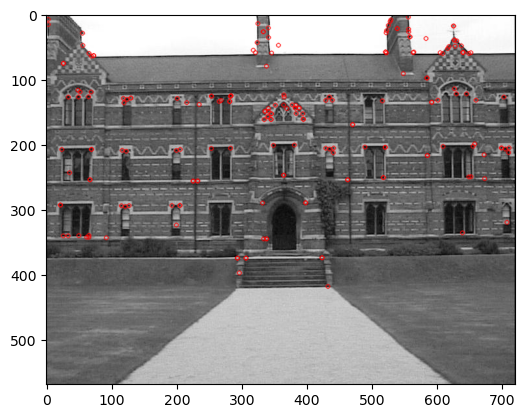

In [29]:
img_gs_b = cv2.imread('./images/keble_b.jpg', cv2.IMREAD_GRAYSCALE)
kp_b, d_b = get_the_N_information(img_gs_b)

In [68]:
def create_distance_matrix(descriptor_1, descriptor_2):
    width = descriptor_1.shape[0]
    distance = np.zeros((width, width))
    for i in range(width):
        one_row_matrix = np.reshape(descriptor_1[i], (1, -1)).repeat(width, 0)
        dist = np.sqrt(np.sum((one_row_matrix - descriptor_2) ** 2, 1))
        distance[i] = dist
    return distance

def NN_and_cross_validation(distance_matrix):
    size = distance_matrix.shape[0]
    threshold = .75
    correspondances = []
    for i in range(size):
        line = distance_matrix[i]
        # Obtein the 1NN and the 2NN
        first_and_second = np.sort(line)[:2]
        # Apply 1NN/2NN threshold
        if (first_and_second[0] / first_and_second[1]) < threshold:
            ind = np.argmin(line)
            # Apply cross validation check
            if np.argmin(distance_matrix[:, ind]) == i:
                # correspondances.append([i, ind])
                match = cv2.DMatch(i, ind, first_and_second[0])
                correspondances.append(match)
    return correspondances

def create_correspondances(descriptor_1, descriptor_2):
    dis = create_distance_matrix(descriptor_1, descriptor_2)
    corr = NN_and_cross_validation(dis)
    return corr

There are 53 correspondances out of 200.


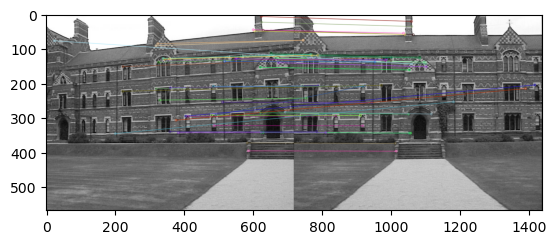

(<matplotlib.image.AxesImage at 0x1475df650>, None)

In [89]:
# Create the correspondances
correspondances = create_correspondances(d_a, d_b)
print('There are {} correspondances out of 200.'.format(len(correspondances)))

# Show the matches
img3 = cv2.drawMatches(img_gs_a, kp_a, img_gs_b, kp_b, correspondances, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(img3),plt.show()

The number of keypoints with sift is 4014
There are 57 correspondances out of 200.


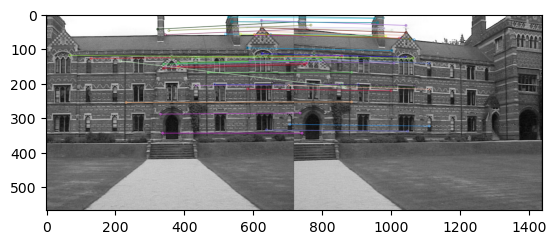

(<matplotlib.image.AxesImage at 0x1448309e0>, None)

In [90]:
# Open the images
img_gs_c = cv2.imread('./images/keble_c.jpg', cv2.IMREAD_GRAYSCALE)
kp_c, d_c = get_the_N_information(img_gs_c)

# Create the correspondances
correspondances2 = create_correspondances(d_b, d_c)
print('There are {} correspondances out of 200.'.format(len(correspondances2)))

# Show the matches
matches2 = cv2.drawMatches(img_gs_b, kp_b, img_gs_c, kp_c, correspondances2, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(matches2),plt.show()

## FAST Descriptors

The number of keypoints with sift is 9035


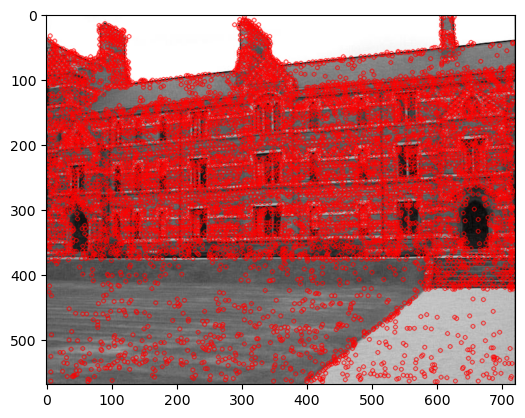

In [36]:
# Initiate FAST object with default values
fast = cv2.FastFeatureDetector_create()

# find and draw the keypoints
kp = fast.detect(img,None)

print('The number of keypoints with sift is {}'.format(len(kp)))

img_kp = cv2.drawKeypoints(img_gs, kp, None, color=(255,0,0))

plt.imshow(img_kp)

